<a href="https://colab.research.google.com/github/saim-glitch/Freelancing/blob/main/CNN_Image_DataSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import kagglehub
kmader_skin_cancer_mnist_ham10000_path = kagglehub.dataset_download('kmader/skin-cancer-mnist-ham10000')

print('Data source import complete.')


Data source import complete.


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass



In [4]:
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

Total images: 10015

Class distribution:
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


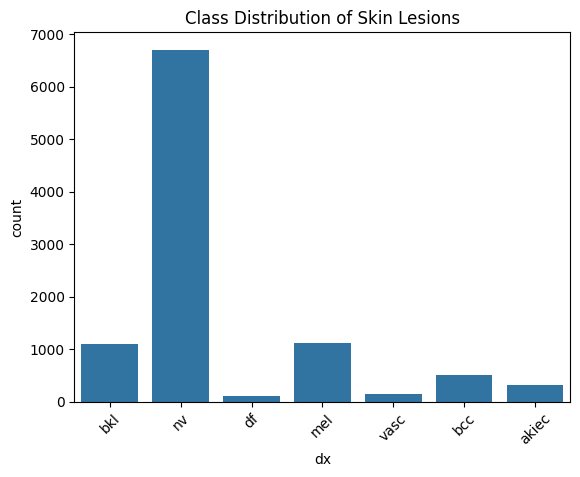

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load metadata
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# Dataset size
print("Total images:", len(df))

# Class distribution
class_counts = df['dx'].value_counts()
print("\nClass distribution:\n", class_counts)

# Plot class balance
sns.countplot(x='dx', data=df)
plt.title("Class Distribution of Skin Lesions")
plt.xticks(rotation=45)
plt.show()


In [9]:
# Parameters
import gc
image_width, image_height = 64, 64

# Initialize lists
original_images = []
resized_images = []
labels = []

# Folders
folders = [
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/',
    '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/',
]

# Memory-efficient processing with original compatibility
print("Loading images with memory optimization...")

# Keep only first 5 original images for visualization
original_samples = []
sample_count = 0

for i, row in df.iterrows():
    image_id = row['image_id'] + '.jpg'
    found = False

    for folder in folders:
        path = os.path.join(folder, image_id)
        if os.path.exists(path):
            img = cv2.imread(path)  # BGR

            if img is not None:
                # Store only first 5 original images for comparison plots
                if sample_count < 5:
                    original_samples.append(img.copy())
                    sample_count += 1

                # Always resize and store
                img_resized = cv2.resize(img, (image_width, image_height),
                                       interpolation=cv2.INTER_LINEAR)
                resized_images.append(img_resized)
                labels.append(row['dx'])
                found = True

                # Clear original image from memory immediately (except samples)
                del img

                # Memory cleanup every 1000 images
                if len(resized_images) % 1000 == 0:
                    gc.collect()
                    print(f"Processed {len(resized_images)} images...")

                break

    if not found:
        print(f"Image {image_id} not found in either folder.")

# Convert to arrays
original_images = np.array(original_samples)  # Only first 5 for visualization
resized_images = np.array(resized_images, dtype=np.uint8)  # Use uint8 to save memory
labels = np.array(labels)

print(f"Original samples shape: {original_images[0].shape if len(original_images) > 0 else 'No samples'}")
print(f"Resized shape: {resized_images[0].shape}")
print(f"Total images processed: {len(resized_images)}")
print(f"Memory usage (resized): ~{resized_images.nbytes / 1024**2:.1f} MB")

# Force memory cleanup

Loading images with memory optimization...
Processed 1000 images...
Processed 2000 images...
Processed 3000 images...
Processed 4000 images...
Processed 5000 images...
Processed 6000 images...
Processed 7000 images...
Processed 8000 images...
Processed 9000 images...
Processed 10000 images...
Original samples shape: (450, 600, 3)
Resized shape: (64, 64, 3)
Total images processed: 10015
Memory usage (resized): ~117.4 MB


In [10]:
import os
import cv2

# Print original size of first found image
for i, row in df.iterrows():
    image_id = row['image_id'] + '.jpg'
    for folder in folders:
        path = os.path.join(folder, image_id)
        if os.path.exists(path):
            img = cv2.imread(path)
            print(f"Original shape of {image_id}: {img.shape}")  # (height, width, channels)
            break
    break  # Exit after first image


Original shape of ISIC_0027419.jpg: (450, 600, 3)


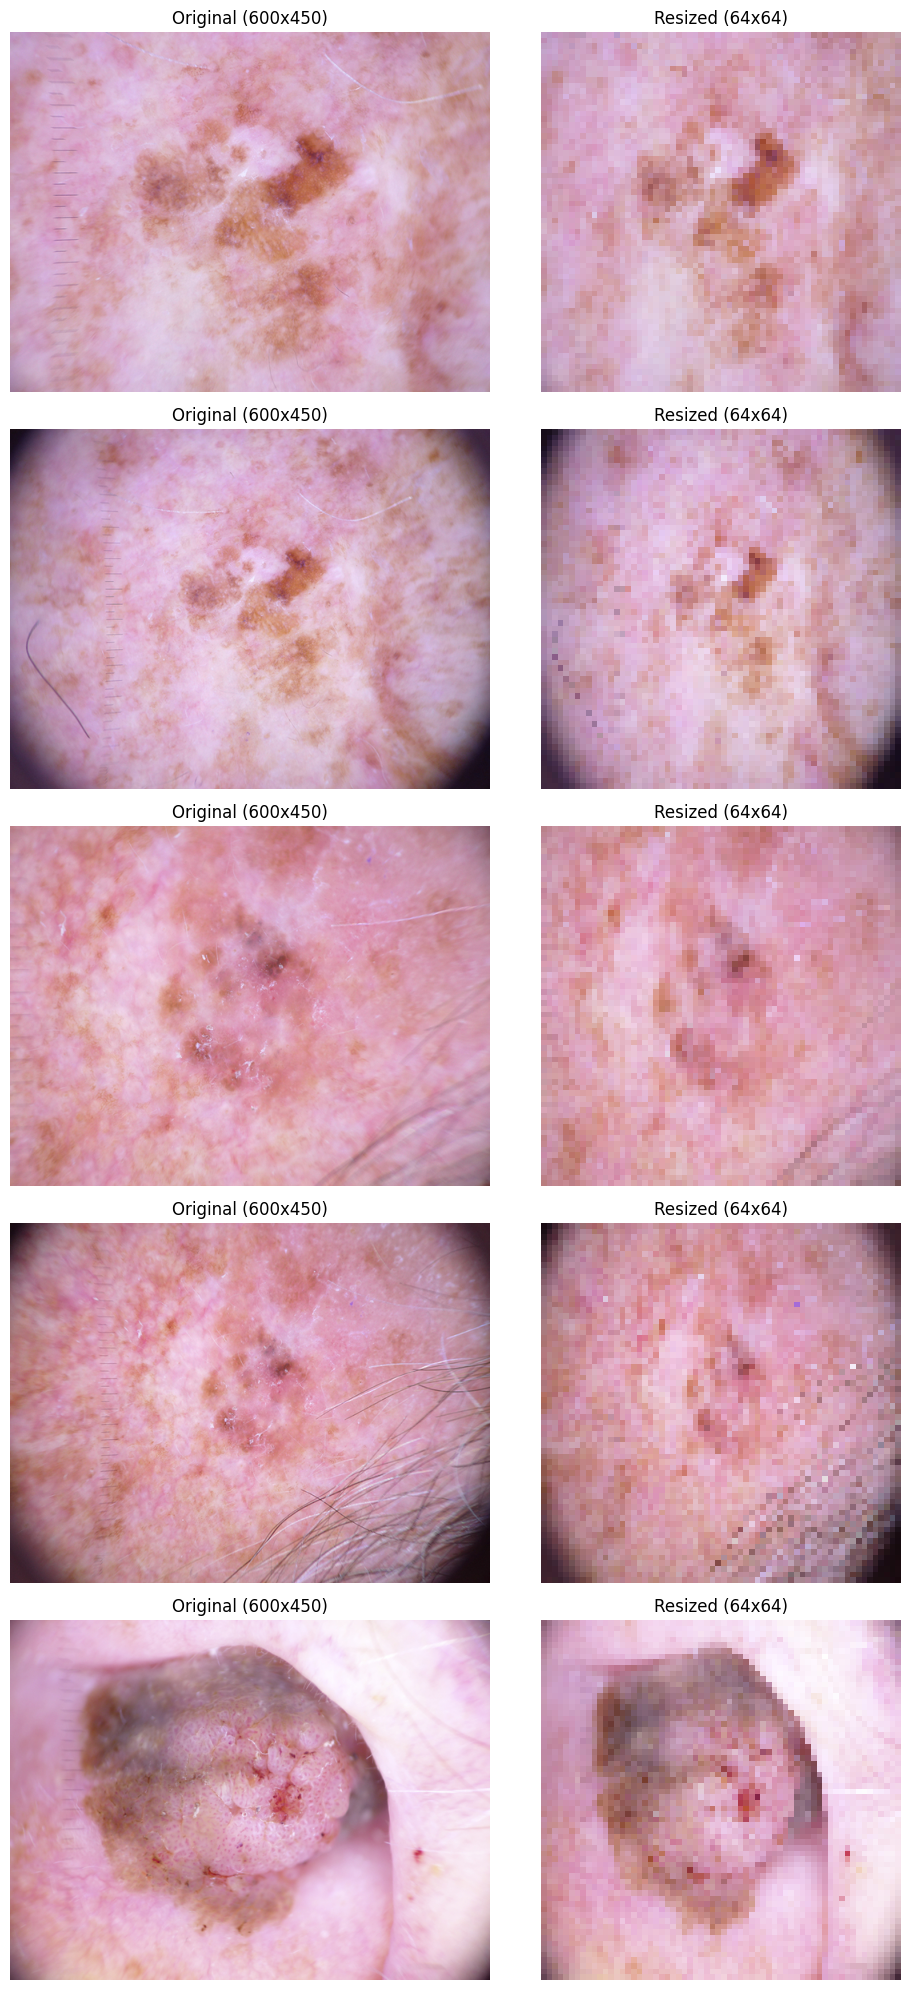

In [11]:
import matplotlib.pyplot as plt
import cv2

# Number of images to compare
num_samples = 5

# Set figure size dynamically
plt.figure(figsize=(10, 4 * num_samples))

for i in range(num_samples):
    # Convert BGR (OpenCV) to RGB (matplotlib)
    original_rgb = cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB)
    resized_rgb = cv2.cvtColor(resized_images[i], cv2.COLOR_BGR2RGB)

    # Plot original image
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.imshow(original_rgb)
    plt.title(f"Original ({original_rgb.shape[1]}x{original_rgb.shape[0]})")
    plt.axis('off')

    # Plot resized image
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.imshow(resized_rgb)
    plt.title(f"Resized (64x64)")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [13]:
from glob import glob

base_skin_dir = '../input/skin-cancer-mnist-ham10000'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [14]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

In [15]:
df['age']=df['age'].fillna((df['age'].mean()), inplace=True)


/tmp/ipython-input-718875565.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age']=df['age'].fillna((df['age'].mean()), inplace=True)


In [17]:
# Fix the path mapping
base_skin_dir = '/kaggle/input/skin-cancer-mnist-ham10000'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes

df['age'] = df['age'].fillna(df['age'].mean())

# Fix: Filter out None paths and load images safely
def load_image_safe(path):
    if path is None:
        return None
    try:
        return np.asarray(Image.open(path).resize((100,75)))
    except:
        return None

df['image'] = df['path'].map(load_image_safe)

# Remove rows with missing images
df = df.dropna(subset=['image']).reset_index(drop=True)
print(f"Dataset size after removing missing images: {len(df)}")

/tmp/ipython-input-647820641.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['age'] = df['age'].fillna(df['age'].mean())


Dataset size after removing missing images: 10015


In [18]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']

In [19]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=52)

In [20]:
x_train = np.array(x_train_o['image'].tolist())
x_test = np.array(x_test_o['image'].tolist())

x_train = (x_train - np.mean(x_train)) / np.std(x_train)
x_test = (x_test - np.mean(x_test)) / np.std(x_test)

In [21]:
y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

In [22]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.1, random_state=51)

In [23]:
x_train = x_train.reshape(-1, 75, 100, 3)
x_validate = x_validate.reshape(-1, 75, 100, 3)
x_test = x_test.reshape(-1, 75, 100, 3)

## Model Creation

In [24]:
import cv2
import numpy as np

def segment_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    segmented = cv2.bitwise_and(image, image, mask=mask)
    return segmented


In [25]:
import matplotlib.pyplot as plt

def apply_segmentation_and_show(x_data, num_samples=2):
    segmented_images = []

    for i in range(len(x_data)):
        original = (x_data[i] * 255).astype(np.uint8)
        segmented = segment_image(original)
        segmented = segmented.astype(np.float32) / 255.0  # normalize
        segmented_images.append(segmented)

        # Display a few samples
        if i < num_samples:
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))
            axes[0].imshow(original)
            axes[0].set_title('Original')
            axes[0].axis('off')
            axes[1].imshow(segmented)
            axes[1].set_title('Segmented')
            axes[1].axis('off')
            plt.tight_layout()
            plt.show()

    return np.array(segmented_images)


In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(75, 100, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.40),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 100, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,752,999 (14.32 MB)

 Trainable params: 3,752,999 (14.32 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(x_train)

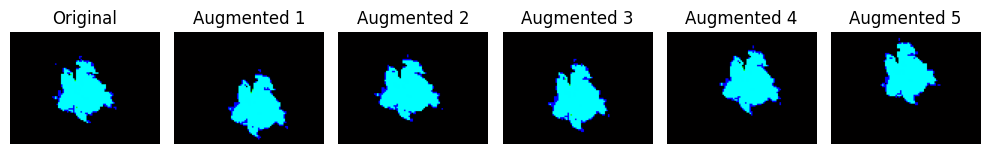

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train is a NumPy array with shape (num_samples, height, width, channels)

# Select one sample image from the training set
sample_image = x_train[0]  # You can change the index to view other images
sample_image = np.expand_dims(sample_image, 0)  # Add batch dimension

# Create an iterator for augmented images
aug_iter = datagen.flow(sample_image, batch_size=1)

# Plot original and augmented images side-by-side
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 6, 1)
plt.imshow(x_train[0].astype("uint8"))
plt.title("Original")
plt.axis('off')

# Show 5 Augmented Versions
for i in range(2, 7):
    augmented_image = next(aug_iter)[0].astype("uint8")
    plt.subplot(1, 6, i)
    plt.imshow(augmented_image)
    plt.title(f"Augmented {i-1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [29]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=7, verbose=1, factor=0.5, min_lr=1e-5)

In [30]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=200,
    validation_data=(x_validate, y_validate),
    steps_per_epoch=x_train.shape[0] // 10,
    callbacks=[lr_reduction],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
 57/721 ━━━━━━━━━━━━━━━━━━━━ 3:46 341ms/step - accuracy: 0.5794 - loss: 1.4834

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


721/721 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.6304 - loss: 1.2221 - val_accuracy: 0.6733 - val_loss: 0.9878 - learning_rate: 0.0010
Epoch 2/200
721/721 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - accuracy: 0.6612 - loss: 0.9607 - val_accuracy: 0.6796 - val_loss: 0.8428 - learning_rate: 0.0010
Epoch 3/200
721/721 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6719 - loss: 0.8989 - val_accuracy: 0.6933 - val_loss: 0.8390 - learning_rate: 0.0010
Epoch 4/200
721/721 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.6862 - loss: 0.8650 - val_accuracy: 0.7132 - val_loss: 0.7991 - learning_rate: 0.0010
Epoch 5/200
721/721 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6919 - loss: 0.8437 - val_accuracy: 0.7120 - val_loss: 0.7563 - learning_rate: 0.0010
Epoch 6/200
721/721 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.6964 - loss: 0.8238 - val_accuracy: 0.7244 - val_loss: 0.7518 - learning_rate: 0.0010
Epoch 7/200
721/721 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.7059 - loss: 

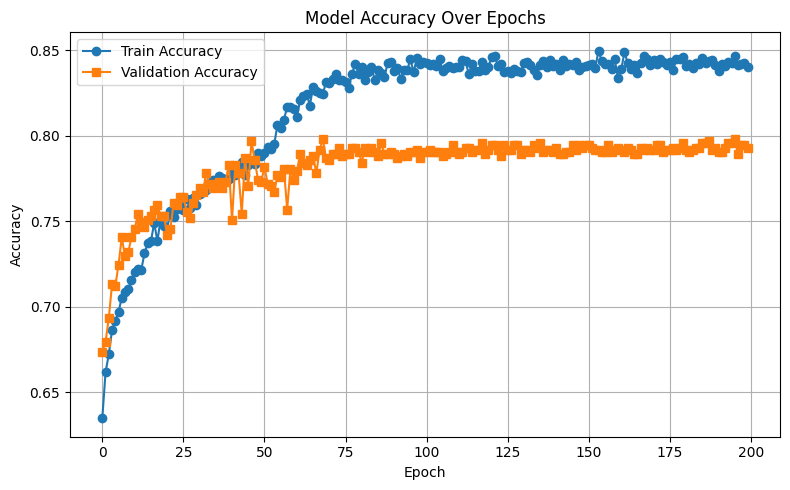

In [31]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


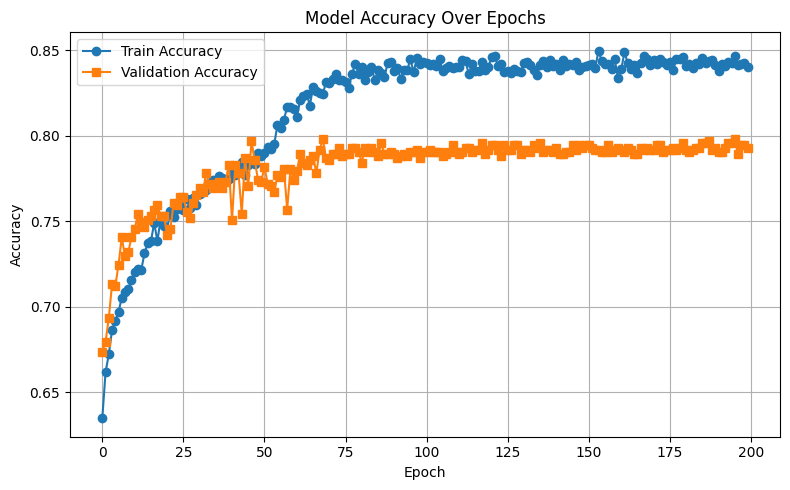

In [32]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
val_loss, val_acc = model.evaluate(x_validate, y_validate, verbose=1)

print(f"Validation Accuracy: {val_acc:.4f}  |  Validation Loss: {val_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}       |  Test Loss: {test_loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7825 - loss: 0.6507
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8079 - loss: 0.6701
Validation Accuracy: 0.7930  |  Validation Loss: 0.6919
Test Accuracy: 0.7913       |  Test Loss: 0.6528


In [34]:
# Predict probabilities on test data
y_pred_probs = model.predict(x_test)

# Convert one-hot encoded true labels and predictions to class indices
y_true_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test Accuracy: 0.7913


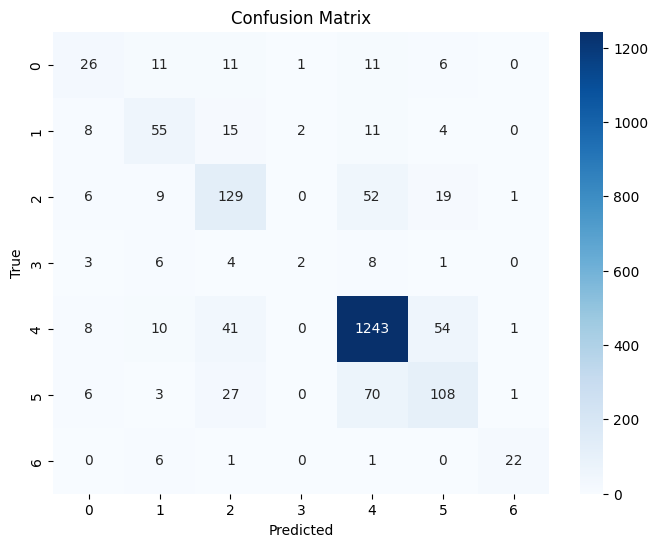

              precision    recall  f1-score   support

     Class 0       0.46      0.39      0.42        66
     Class 1       0.55      0.58      0.56        95
     Class 2       0.57      0.60      0.58       216
     Class 3       0.40      0.08      0.14        24
     Class 4       0.89      0.92      0.90      1357
     Class 5       0.56      0.50      0.53       215
     Class 6       0.88      0.73      0.80        30

    accuracy                           0.79      2003
   macro avg       0.61      0.54      0.56      2003
weighted avg       0.78      0.79      0.79      2003

Class 0: Precision=0.46, Recall=0.39, F1-Score=0.42
Class 1: Precision=0.55, Recall=0.58, F1-Score=0.56
Class 2: Precision=0.57, Recall=0.60, F1-Score=0.58
Class 3: Precision=0.40, Recall=0.08, F1-Score=0.14
Class 4: Precision=0.89, Recall=0.92, F1-Score=0.90
Class 5: Precision=0.56, Recall=0.50, F1-Score=0.53
Class 6: Precision=0.88, Recall=0.73, F1-Score=0.80


In [35]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Get predicted classes and true classes
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# 2. Calculate accuracy
acc = accuracy_score(y_true_classes, y_pred_classes)
print(f"Test Accuracy: {acc:.4f}")

# 3. Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 4. Classification report (includes precision, recall, f1-score)
class_names = [f'Class {i}' for i in range(7)]  # Change if you have actual class names
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

# 5. (Optional) Extract precision, recall, f1-score per class separately
precision, recall, f1, _ = precision_recall_fscore_support(y_true_classes, y_pred_classes)

for i, cls in enumerate(class_names):
    print(f"{cls}: Precision={precision[i]:.2f}, Recall={recall[i]:.2f}, F1-Score={f1[i]:.2f}")


In [36]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("/kaggle/working/skin_cancer_analysis.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp1vkmwl2k'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 75, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  139062668709712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062668712784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062668710480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062668712976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062668713168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062668713936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062668713744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062668714512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062668714896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062668716432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139062668715856

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/skin_cancer_analysis.tflite'

In [37]:
# Load metadata
df_metadata = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

# Show the first few rows
df_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🧠 Predicted class : Actinic keratoses  (Confidence: 1.0000)
✅ Actual class    : nv

🔎 All class probabilities:
  Melanocytic nevi              : 0.0000
  Melanoma                      : 0.0000
  Benign keratosis-like lesions : 0.0000
  Basal cell carcinoma          : 0.0000
  Actinic keratoses             : 1.0000
  Vascular lesions              : 0.0000
  Dermatofibroma                : 0.0000


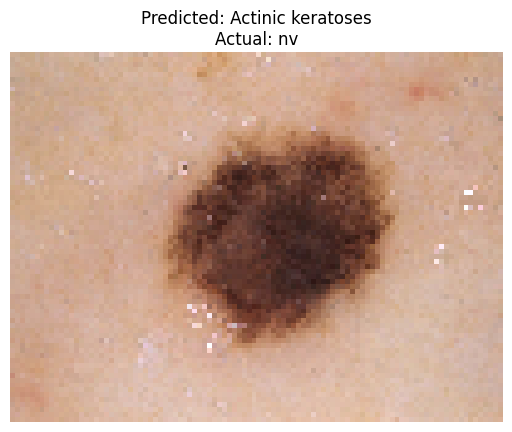

In [38]:
from tensorflow.keras.preprocessing import image

### from tensorflow.keras.preprocessing import image
lesion_types = [
    'Melanocytic nevi',
    'Melanoma',
    'Benign keratosis-like lesions',
    'Basal cell carcinoma',
    'Actinic keratoses',
    'Vascular lesions',
    'Dermatofibroma'
]

import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os

def predict_single_skin_image(img_path, model, class_names, df_metadata, image_size=(75, 100)):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=image_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = (img_array - np.mean(img_array)) / np.std(img_array)

    # Predict
    preds = model.predict(img_array)[0]
    pred_idx = np.argmax(preds)
    pred_prob = preds[pred_idx]
    pred_label = class_names[pred_idx]

    # Get actual label from metadata
    image_id = os.path.splitext(os.path.basename(img_path))[0]
    actual_label_row = df_metadata[df_metadata['image_id'] == image_id]
    actual_label = actual_label_row['dx'].values[0] if not actual_label_row.empty else "Unknown"

    # Print results
    print(f"🧠 Predicted class : {pred_label}  (Confidence: {pred_prob:.4f})")
    print(f"✅ Actual class    : {actual_label}")
    print("\n🔎 All class probabilities:")
    for i, name in enumerate(class_names):
        print(f"  {name:30s}: {preds[i]:.4f}")

    # Display image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_label}\nActual: {actual_label}")
    plt.show()

test_img = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024319.jpg'
predict_single_skin_image(test_img, model, lesion_types, df_metadata)

